# 2.1 Calibration
Prepared by (C) Vasken Dermardiros

Here, we will be using the 1U1C model again, however, it'll be stored away nicely in a seperate ".py" file called mU1C1.py; the *m* is for *model*.

The objective is to determine the values of the conductance and capacitance that best fits the data. We will be using scipy for the optimization. We could also be using a Kalman filter based approach. A higher order model is also a possibility.

Let's begin by importing the model and the data. The data comes from an EnergyPlus simulation for a small office with a single south facing window. The office is located in Montreal. All the necessary files to rerun the simulation are found in the "\code_base" folder.

We will split the data in two sets for (1) training and (2) cross-validation.

## Load Dependencies

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
# Plot in notebook; comment out the line below for windowed plots
%matplotlib inline
# mpl.rc('figure', figsize=(10, 10))
from scipy.optimize import minimize
import pandas as pd

# Import mU1C1 script
from code_base import mU1C1
# Extra scripts to keep this notebook simple and tidy
from code_base import simfun

## Load EnergyPlus Data
Of course, it can come from another source. It can be the actual building data from the automation system as well.

We have ran the simulation for the simple room for a year but have extracted the information for 5 days (February 22nd to 26th). The building is located in Montreal.

In [2]:
timestep = 5.       # minutes
dt = timestep*60

# Load EnergyPlus data
data = pd.read_csv('code_base/room_feb22_to_feb26.csv', parse_dates=True, infer_datetime_format=True, index_col=0)
# names = list(data.columns.values) # get headers

# Temperatures and setpoints
T_amb = data['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'].values
T_opr = data['THERMAL ZONE 1:Zone Operative Temperature [C](TimeStep)'].values
T_mrad = data['THERMAL ZONE 1:Zone Mean Radiant Temperature [C](TimeStep)'].values
T_room = data['THERMAL ZONE 1:Zone Mean Air Temperature [C](TimeStep)'].values
HeatSP = data['THERMAL ZONE 1:Zone Thermostat Heating Setpoint Temperature [C](TimeStep)'].values
CoolSP = data['THERMAL ZONE 1:Zone Thermostat Cooling Setpoint Temperature [C](TimeStep)'].values

# Heat Gain is +ve, Heat Loss/Cooling is -ve
People = data['THERMAL ZONE 1 189.1-2009 - OFFICE - CLOSEDOFFICE - CZ4-8 PEOPLE:People Total Heating Rate [W](TimeStep)'].values
Lights = data['THERMAL ZONE 1 189.1-2009 - OFFICE - CLOSEDOFFICE - CZ4-8 LIGHTS:Lights Electric Power [W](TimeStep)'].values
Equip = data['THERMAL ZONE 1 189.1-2009 - OFFICE - CLOSEDOFFICE - CZ4-8 ELECTRIC EQUIPMENT:Electric Equipment Electric Power [W](TimeStep)'].values
QSol = data['THERMAL ZONE 1:Zone Windows Total Heat Gain Rate [W](TimeStep)'].values \
        - data['THERMAL ZONE 1:Zone Windows Total Heat Loss Rate [W](TimeStep)'].values # sun going through window
SInfGain = (1/(60.*timestep))*data['THERMAL ZONE 1:Zone Infiltration Sensible Heat Gain Energy [J](TimeStep)'].values
SInfLoss = (-1/(60.*timestep))*data['THERMAL ZONE 1:Zone Infiltration Sensible Heat Loss Energy [J](TimeStep)'].values
SHeat = data['THERMAL ZONE 1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Supply Air Sensible Heating Rate [W](TimeStep)'].values
SCool = (-1)*data['THERMAL ZONE 1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Supply Air Sensible Cooling Rate [W](TimeStep) '].values

# Total
Q_total = People + Lights + Equip + QSol + SInfGain + SInfLoss + SHeat + SCool

# Number of timesteps = number of data points loaded
nt = len(Q_total)
split = int(3./5*nt) # use 3.5 days out of 5 for training, and the rest for cross-validation

### Plot Imported Data

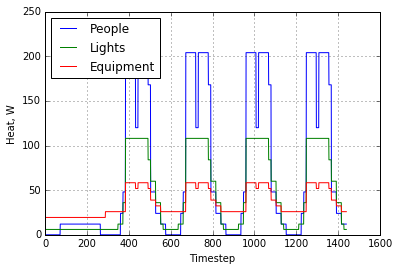

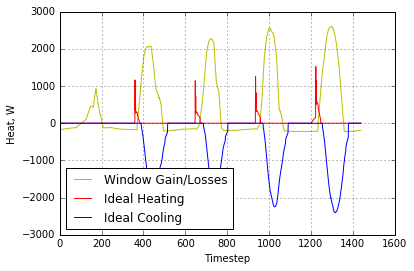

In [7]:
plt.figure()
plt.plot(People,'b', label='People')
plt.plot(Lights,'g', label='Lights')
plt.plot(Equip,'r', label='Equipment')
plt.xlabel('Timestep')
plt.ylabel('Heat, W')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure()
plt.plot(QSol,'y', label='Window Gain/Losses')
plt.plot(SHeat,'r', label='Ideal Heating')
plt.plot(SCool,'b', label='Ideal Cooling')
plt.xlabel('Timestep')
plt.ylabel('Heat, W')
plt.legend(loc='best')
plt.grid()
plt.show()

## Cost functions for the calibration

In [4]:
# Euclidean distance based cost function
def costEuclidean((U_in, C_in), Q, initialT, TK, dt, testT):
    U_inv, F, C, nN, nM = mU1C1.mU1C1(U_in, C_in, dt)
    # Calculate the future temperatures
    T = simfun.futureT(Q, initialT, TK, U_inv, F, C, nN, dt)
    err = T - testT                    # setpoint error
    return np.sqrt(np.dot(err.T, err)) # sqrt[sum(error^2)]

# NMBE based cost function [normalized mean bias error]
def costNMBE((U_in, C_in), Q, initialT, TK, dt, testT):
    U_inv, F, C, nN, nM = mU1C1.mU1C1(U_in, C_in, dt)
    # Calculate the future temperatures
    T = simfun.futureT(Q, initialT, TK, U_inv, F, C, nN, dt)
    err = T - testT                    # setpoint error
    return np.abs(np.sum(err))/(np.mean(testT)*(len(testT)-1))

# CV(RMSE) based cost function 
# [coefficient of variance of the root mean square error]
def costCVRMSE((U_in, C_in), Q, initialT, TK, dt, testT):
    U_inv, F, C, nN, nM = mU1C1.mU1C1(U_in, C_in, dt)
    # Calculate the future temperatures
    T = simfun.futureT(Q, initialT, TK, U_inv, F, C, nN, dt)
    err = T - testT                    # setpoint error
    return 1/np.mean(testT)*np.sqrt(np.dot(err.T, err)/(len(testT)-2))

## Match U1C1 Model to EnergyPlus Data

In [5]:
# Train RC model - 1st order
x0 = [1., 1e6]              # initial guess

# Extra arguments to send to cost function, Q_total, temperatures, timestep...
args = Q_total[0:split].reshape(split,1), T_opr[0], \
       T_amb[0:split].reshape(split,1), dt, T_opr[0:split].reshape(split,1)
bnds = ((0, None), (0, None)) # bounds, None = not bounded

# You may want to test all the cost functions and maybe different
# minimization algorithms. The "simplex-based" Nelder-Mead algorithm
# performs well here (it can't handle bounds though). 
res = minimize(costEuclidean, x0, method='Nelder-Mead', args=args,
               options={'ftol': 1e-6, 'disp': True, 'maxiter': 2000})
# res = minimize(costEuclidean, x0, method='SLSQP', args=args, bounds=bnds, 
#                options={'ftol': 1e-12, 'disp': True, 'maxiter': 2000})

print("Best values for U and C: %s" % res.x)
U_best, C_best = res.x

# Calculate T for the U1C1 model using the obtained results
U_inv, F, C, nN, __ = mU1C1.mU1C1(U_best, C_best, dt)
T_train = simfun.futureT(args[0], args[1], args[2], U_inv, F, C, nN, dt)
T_cross = simfun.futureT(Q_total[split::].reshape(nt-split,1),
                         T_opr[split], T_amb[split::].reshape(nt-split,1),
                         U_inv, F, C, nN, dt)

Optimization terminated successfully.
         Current function value: 26.112702
         Iterations: 93
         Function evaluations: 193
Best values for U and C: [  2.75701373e+00   1.97257015e+06]


### Plot Both U1C1 and EnergyPlus Data

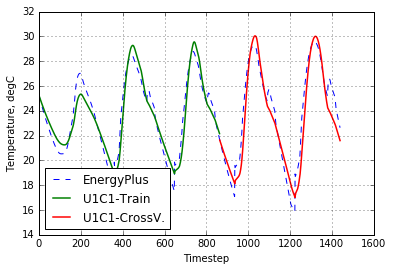

In [6]:
plt.figure()
plt.plot(T_opr, 'b--', label='EnergyPlus')
plt.plot(range(split), T_train, 'g', lw=1.5, label='U1C1-Train')
plt.plot(range(split,nt), T_cross,'r', lw=1.5, label='U1C1-CrossV.')
plt.xlabel('Timestep')
plt.ylabel('Temperature, degC')
plt.legend(loc='best')
plt.grid()
plt.show()